<h2> Analyzing Performance of CNN for Audio Processing with MFCC of Varying Orders: </h2>

In [1]:
import json
import librosa
import numpy as np
import tensorflow as tf

/Users/xenexjoshi/Music Genre Classification/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
DATA_PATH = "data.json"

def load_data(data_path = DATA_PATH):
  with open(data_path, "r") as fp:
    data = json.load(fp)

  mfcc = np.array(data["mfcc"])
  labels = np.array(data["labels"])
  return mfcc, labels

In [3]:
def generate_mfcc_orders(mfcc):
  delta_mfcc = librosa.feature.delta(mfcc, order = 1)
  delta2_mfcc = librosa.feature.delta(mfcc, order = 2)
  return delta_mfcc, delta2_mfcc

In [4]:
from sklearn.model_selection import train_test_split

def split_data(features, labels):
  X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.30, random_state = 42)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.15, random_state = 42)
  return X_train, X_test, X_val, y_train, y_test, y_val

In [5]:
import tensorflow.keras as keras

def generate_cnn_model(input_shape):
  model = keras.Sequential()

  model.add(keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = input_shape))
  model.add(keras.layers.MaxPool2D((3, 3), strides = (2, 2), padding = 'same'))
  model.add(keras.layers.BatchNormalization())

  model.add(keras.layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = input_shape))
  model.add(keras.layers.MaxPool2D((3, 3), strides = (2, 2), padding = 'same'))
  model.add(keras.layers.BatchNormalization())

  model.add(keras.layers.Conv2D(128, (2, 2), activation = 'relu', input_shape = input_shape))
  model.add(keras.layers.MaxPool2D((2, 2), strides = (2, 2), padding = 'same'))
  model.add(keras.layers.BatchNormalization())

  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(64, activation = 'relu'))
  model.add(keras.layers.Dropout(0.3))

  model.add(keras.layers.Dense(10, activation = 'softmax'))
  print("CNN model loaded.")
  return model

In [6]:
mfcc, labels = load_data(DATA_PATH)
delta_mfcc, delta2_mfcc = generate_mfcc_orders(mfcc = mfcc)

print(mfcc.shape)
print(delta_mfcc.shape)
print(delta2_mfcc.shape)

(9989, 132, 13)
(9989, 132, 13)
(9989, 132, 13)


<h3> CNN trained on MFCC: </h3>

In [7]:
# Splitting dataset into training, testing, and validation set
X_train, X_test, X_validation, y_train, y_test, y_validation = split_data(mfcc, labels)

# Adding extra dimension to data for increased stability
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]

print(mfcc.shape)

# Generating input dimension to the CNN
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
print(input_shape)

(9989, 132, 13)
(132, 13, 1)


In [8]:
# Generating CNN model for input dimension based on MFCC
model_mfcc = generate_cnn_model(input_shape)

# Initializing Adam optimizer for CNN model
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

# Compiling the model with Adam optimizer
model_mfcc.compile(optimizer = optimizer,
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

model_mfcc.summary()

CNN model loaded.


/Users/xenexjoshi/Music Genre Classification/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 130, 11, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 65, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 65, 6, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 63, 4, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 2, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 31, 1, 128)     │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 1, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,394 (720.29 KB)

 Trainable params: 183,946 (718.54 KB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
# Training model on the training set, while using the validation to check validation accuracy after each epoch
base_history = model_mfcc.fit(X_train, y_train, validation_data = (X_validation, y_validation), epochs = 30, batch_size = 32)

Epoch 1/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.2550 - loss: 2.3688 - val_accuracy: 0.4404 - val_loss: 1.6178
Epoch 2/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.4789 - loss: 1.4967 - val_accuracy: 0.5834 - val_loss: 1.2324
Epoch 3/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.5629 - loss: 1.2581 - val_accuracy: 0.6092 - val_loss: 1.1197
Epoch 4/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.6086 - loss: 1.0949 - val_accuracy: 0.6282 - val_loss: 1.0722
Epoch 5/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.6504 - loss: 1.0071 - val_accuracy: 0.6549 - val_loss: 0.9837
Epoch 6/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.6922 - loss: 0.8993 - val_accuracy: 0.6473 - val_loss: 0.9872
Epoch 7/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.7269 - loss: 0.7981 - val_accuracy: 0.6702 - val_loss: 0.9131
Epoch 8/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.7265 - loss: 0.7796 - val_accu

In [10]:
# Evaluating the model with the testing set
_, accuracy = model_mfcc.evaluate(X_test, y_test)
print("Model accuracy: " + str(round(100 * accuracy, 3)) + "%.")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7365 - loss: 0.8176
Model accuracy: 74.341%.


<h3> CNN trained on MFCC and first-order delta MFCC: </h3>

In [11]:
# Merging MFCC and delta(MFCC) into a 2d structure to pass onto the CNN
complex_feature = np.stack([mfcc, delta_mfcc], axis = -1)
print(complex_feature.shape)

# Splitting dataset into training, testing, and validation set
X_train, X_test, X_validation, y_train, y_test, y_validation = split_data(complex_feature, labels)

# Generating input dimension to the CNN
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
print(input_shape)

(9989, 132, 13, 2)
(132, 13, 2)


In [12]:
# Generating CNN model for input dimension based on MFCC and delta MFCC
model_delta = generate_cnn_model(input_shape)

# Initializing Adam optimizer for CNN model
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

# Compiling the model with Adam optimizer
model_delta.compile(optimizer = optimizer,
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

model_delta.summary()

CNN model loaded.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 130, 11, 32)    │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 65, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 65, 6, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 63, 4, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 2, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 31, 1, 128)     │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 1, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,682 (721.41 KB)

 Trainable params: 184,234 (719.66 KB)

 Non-trainable params: 448 (1.75 KB)

In [13]:
# Training model on the training set, while using the validation to check validation accuracy after each epoch
first_order_history = model_delta.fit(X_train, y_train, validation_data = (X_validation, y_validation), epochs = 30, batch_size = 32)

Epoch 1/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.2437 - loss: 2.4251 - val_accuracy: 0.4538 - val_loss: 1.5835
Epoch 2/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.4523 - loss: 1.5553 - val_accuracy: 0.5624 - val_loss: 1.2494
Epoch 3/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.5515 - loss: 1.2925 - val_accuracy: 0.5977 - val_loss: 1.1471
Epoch 4/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.5921 - loss: 1.1509 - val_accuracy: 0.6254 - val_loss: 1.0689
Epoch 5/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.6513 - loss: 1.0083 - val_accuracy: 0.6520 - val_loss: 1.0090
Epoch 6/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.6675 - loss: 0.9333 - val_accuracy: 0.6606 - val_loss: 0.9598
Epoch 7/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.7044 - loss: 0.8712 - val_accuracy: 0.6797 - val_loss: 0.9267
Epoch 8/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.7221 - loss: 0.7824 - val_acc

In [14]:
# Evaluating the model with the testing set
_, accuracy = model_delta.evaluate(X_test, y_test)
print("Model accuracy: " + str(round(100 * accuracy, 3)) + "%.")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7549 - loss: 0.7514
Model accuracy: 75.609%.


<h3> CNN trained on MFCC, first-order, and second-order delta MFCC: </h3>

In [15]:
# Merging MFCC, delta_MFCC, and delta2_MFCC into a 2D structure to pass onto the CNN
complex_feature = np.stack([mfcc, delta_mfcc, delta2_mfcc], axis = -1)
print(complex_feature.shape)

# Splitting dataset into training, testing, and validation set
X_train, X_test, X_validation, y_train, y_test, y_validation = split_data(complex_feature, labels)

# Generating input dimension to the CNN
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
print(input_shape)

(9989, 132, 13, 3)
(132, 13, 3)


In [16]:
# Generating CNN model for input dimension based on MFCC, delta MFCC, and delta_2 MFCC
model_delta = generate_cnn_model(input_shape)

# Initializing Adam optimizer for CNN model
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

# Compiling the model with Adam optimizer
model_delta.compile(optimizer = optimizer,
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

model_delta.summary()

CNN model loaded.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 130, 11, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 65, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 65, 6, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 63, 4, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 2, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 31, 1, 128)     │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 1, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,970 (722.54 KB)

 Trainable params: 184,522 (720.79 KB)

 Non-trainable params: 448 (1.75 KB)

In [17]:
# Training model on the training set, while using the validation to check validation accuracy after each epoch
second_order_history = model_delta.fit(X_train, y_train, validation_data = (X_validation, y_validation), epochs = 30, batch_size = 32)

Epoch 1/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.2607 - loss: 2.3242 - val_accuracy: 0.4223 - val_loss: 1.6352
Epoch 2/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.4997 - loss: 1.4432 - val_accuracy: 0.5510 - val_loss: 1.2751
Epoch 3/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.5408 - loss: 1.2542 - val_accuracy: 0.6044 - val_loss: 1.1613
Epoch 4/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.6120 - loss: 1.1032 - val_accuracy: 0.6149 - val_loss: 1.0792
Epoch 5/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.6716 - loss: 0.9643 - val_accuracy: 0.6292 - val_loss: 1.0347
Epoch 6/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.6919 - loss: 0.8630 - val_accuracy: 0.6511 - val_loss: 0.9742
Epoch 7/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.7194 - loss: 0.8015 - val_accuracy: 0.6625 - val_loss: 0.9686
Epoch 8/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.7406 - loss: 0.7371 - val_accu

In [18]:
# Evaluating the model with the testing set
_, accuracy = model_delta.evaluate(X_test, y_test)
print("Model accuracy: " + str(round(100 * accuracy, 3)) + "%.")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7528 - loss: 0.8147
Model accuracy: 75.409%.


<h3> Analysis: </h3>

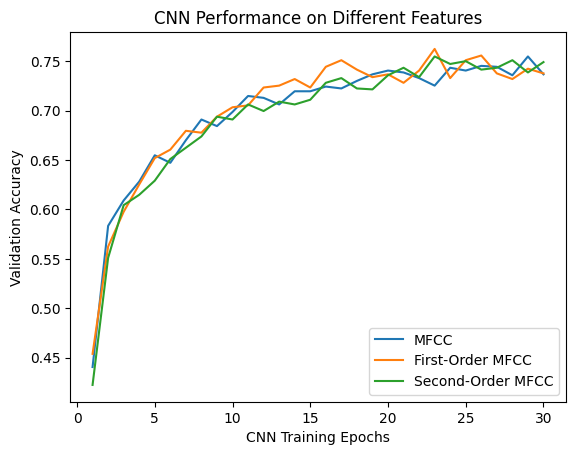

In [19]:
import matplotlib.pyplot as plt

x_range = range(1, 31)
plt.plot(x_range, base_history.history['val_accuracy'], label = 'MFCC')
plt.plot(x_range, first_order_history.history['val_accuracy'], label = 'First-Order MFCC')
plt.plot(x_range, second_order_history.history['val_accuracy'], label = 'Second-Order MFCC')
plt.xlabel('CNN Training Epochs')
plt.ylabel('Validation Accuracy')
plt.title('CNN Performance on Different Features')
plt.legend()
plt.show()

<h3> Conclusion: </h3>

<p> </p>